In [ ]:
%%capture
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
  # Normal packages
  %pip install lightning polars segmentation_models_pytorch
  # Dev packages
  %pip install icecream rich tqdm

In [ ]:
from pathlib import Path

import polars as pl
import torch
import torch.nn as nn
from torchvision.io import decode_image
from torchvision.transforms import v2
from torchvision.tv_tensors import Image, Mask
import lightning as L
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.loggers import CSVLogger
import torchmetrics
import torchmetrics.segmentation
import segmentation_models_pytorch as smp

# Dev Imports
from icecream import ic

class SegmentationData(L.LightningDataModule):
  def __init__(self, ws_root: Path = Path("."), num_workers=0):
    super().__init__()
    self.data_path = ws_root / 'segmentation_dataset' / 'data'
    self.image_names = list(f.stem for f in (self.data_path / "masks").iterdir())

    self.dataloader_extras = dict(
        num_workers = num_workers,
        pin_memory = True,
        persistent_workers = num_workers > 0
    )

    self.n_classes = 1

  def setup(self, stage: str):
    train, val, test = torch.utils.data.random_split(self.image_names, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))
    self.train_ds = ImageDataset(train, self.data_path, training=True)
    self.val_ds = ImageDataset(val, self.data_path, training=True)
    self.test_ds = ImageDataset(test, self.data_path)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_ds, batch_size=16, shuffle=True, **self.dataloader_extras)

  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_ds, batch_size=64, **self.dataloader_extras)

  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_ds, batch_size=1, **self.dataloader_extras)

class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, image_names, data_path, training=False):
    super().__init__()
    self.mask_path = data_path / "masks"
    self.image_path = data_path / "images"
    self.image_names = image_names

    self.training = training
    self.train_transforms = v2.Compose([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
    ])
    self.transforms = v2.Compose([
        v2.RandomResizedCrop((256, 256)),
        v2.ToDtype(torch.float32, scale=True),
        v2.ToPureTensor(),
    ])

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    image = Image(decode_image(self.image_path / f"{self.image_names[idx]}.jpg", mode="RGB"))
    mask = Mask(decode_image(self.mask_path / f"{self.image_names[idx]}.png", mode="GRAY"))
    if self.training:
      image, mask = self.train_transforms(image, mask)
    image, mask = self.transforms(image, mask)
    mask = (mask > 37).to(torch.long).squeeze()
    return image, mask

class WrappedModel(nn.Module):
  def __init__(self, n_classes, model_type):
    super().__init__()

    model_parameters = dict(classes = n_classes, encoder_name="resnet50", encoder_weights=None)
    model_dict = {
        "Unet": smp.Unet,
        "UnetPlusPlus": smp.UnetPlusPlus,
        "DeepLabV3": smp.DeepLabV3,
        "MAnet": smp.MAnet,
    }
    if model_type in model_dict:
      self.model = model_dict[model_type](**model_parameters)
    else:
      raise Error(f"model_type {model_type} not supported")

  def forward(self, x):
    x = self.model(x)
    return x

class DownBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    half_ch = out_ch//2
    self.branch1 = nn.Sequential(
      nn.BatchNorm2d(in_ch),
      nn.Dropout2d(),
      nn.Conv2d(in_ch, in_ch, 3, groups=in_ch, stride=2, padding=1),

      nn.BatchNorm2d(in_ch),
      nn.Conv2d(in_ch, half_ch, 1, padding='same'),
      nn.ELU(),
    )

    self.branch2 = nn.Sequential(
      nn.BatchNorm2d(in_ch),
      nn.Dropout2d(),
      nn.Conv2d(in_ch, half_ch, 1, padding='same'),
      nn.ELU(),

      nn.BatchNorm2d(half_ch),
      nn.Conv2d(half_ch, half_ch, 3, groups=half_ch, stride=2, padding=1),
      nn.ELU(),
    )
    self.out_ch = out_ch

  def forward(self, x):
    x1 = torch.nn.functional.pixel_unshuffle(x, 2)
    x2 = torch.cat([self.branch1(x), self.branch2(x)], dim=1)
    x = x1[:, ::2] + x1[:, 1::2] + x2
    return x

class ChDownBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    assert in_ch == out_ch*2
    self.branch2 = nn.Sequential(
      nn.BatchNorm2d(out_ch),
      nn.Dropout2d(),
      nn.Conv2d(out_ch, out_ch, 1, padding='same'),
      nn.ELU(),

      nn.BatchNorm2d(out_ch),
      nn.Conv2d(out_ch, out_ch, 3, groups=out_ch, padding='same', bias=False),

      nn.BatchNorm2d(out_ch),
      nn.Conv2d(out_ch, out_ch, 1, padding='same'),
      nn.ELU(),
    )
    self.c = out_ch

  def forward(self, x):
    x1 = x[:, :self.c, ...]
    x2 = x[:, self.c:, ...]
    x = x1 + self.branch2(x2)
    return x

class CustomModel(nn.Module):
  def __init__(self, num_classes, input_dim=3):
    super().__init__()

    chs = 128 + 32
    self.in_layer = nn.Conv2d(input_dim, chs, 1)

    self.encoder = nn.Sequential(
      DownBlock(chs, chs*2),
      DownBlock(chs*2, chs*4),
      DownBlock(chs*4, chs*8),
      DownBlock(chs*8, chs*16),
      DownBlock(chs*16, chs*32),
    )

    self.decoder = nn.Sequential(
      ChDownBlock(chs*32, chs*16),
      ChDownBlock(chs*16, chs*8),
      ChDownBlock(chs*8, chs*4),
      ChDownBlock(chs*4, chs*2),
      ChDownBlock(chs*2, chs),
      nn.Upsample(scale_factor=2**5, mode='bilinear', align_corners=True),
    )

    self.out_block = nn.Sequential(
      ChDownBlock(chs * 2, chs),

      nn.BatchNorm2d(chs),
      nn.Conv2d(chs, num_classes, 1, padding='same'),
    )

  def forward(self, x):
    x = self.in_layer(x)
    initial_img = x
    x = self.encoder(x)
    x = self.decoder(x)
    x = torch.stack([x, initial_img], dim=1).transpose(1, 2).flatten(1, 2)
    x = self.out_block(x)
    return x

class LitWrappedModel(L.LightningModule):
  def __init__(self, n_classes, model_type):
    super().__init__()
    if "Custom" in model_type:
      self.model = CustomModel(n_classes)
    else:
      self.model = WrappedModel(n_classes, model_type)
    self.n_classes = n_classes

    self.val_metrics = torchmetrics.MetricCollection(
        {
            "pixel_accuracy": torchmetrics.classification.Accuracy(task="binary", num_classes=n_classes),
            "pixel_f1": torchmetrics.classification.F1Score(task="binary", num_classes=n_classes),
            "DICE": torchmetrics.segmentation.GeneralizedDiceScore(num_classes=2, input_format="index"),
            "IOU": torchmetrics.segmentation.MeanIoU(num_classes=2, input_format="index"),
        },
        prefix="val_",
    )
    self.test_metrics = self.val_metrics.clone(prefix="test_")

    self.losses = [smp.losses.DiceLoss('binary'), smp.losses.SoftBCEWithLogitsLoss()]

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self.model(x).squeeze(1)
    loss = sum(loss(y_pred, y.to(torch.float32)) for loss in self.losses)
    self.log("train_loss", loss, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self.model(x)
    y_pred = (y_pred > 0).to(torch.long).squeeze(1)
    self.log_dict(self.val_metrics(y_pred, y), prog_bar=True)

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self.model(x)
    y_pred = (y_pred > 0).to(torch.long).squeeze(1)
    self.log_dict(self.test_metrics(y_pred, y), prog_bar=True)

  def on_validation_epoch_end(self):
    L.pytorch.utilities.memory.garbage_collection_cuda()

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

segmentation_data = SegmentationData(num_workers=15)

for exp_name in ("Unet", "UnetPlusPlus", "DeepLabV3", "MAnet"):
  lit_model = LitWrappedModel(segmentation_data.n_classes, model_type=exp_name)

  trainer = L.Trainer(
      max_epochs=200,
      accelerator='gpu',
      callbacks=[RichProgressBar()],
      logger=CSVLogger("csv_logs/segmentation", name=exp_name, version=0)
  )
  trainer.fit(model=lit_model, datamodule=segmentation_data)

  model_save_path = Path("models") / "segmentation"
  model_save_path = model_save_path / exp_name
  model_save_path.mkdir(exist_ok=True, parents=True)

  model = lit_model.model
  model = model.eval().cpu()
  ## Save just weights
  torch.save(model.state_dict(), model_save_path / f"weights_{exp_name}.pt")
  ## Pickle the whole model
  torch.save(model, model_save_path / f"model_{exp_name}.pt")
  ## Using experimental torch export
  _height = torch.export.Dim('_height', min=1)
  _width = torch.export.Dim('_width', min=1)
  dynamic_shapes = {"x": {
    0: torch.export.Dim("batch", min=1, max=9223372036854775806),
    2: 32*_height,
    3: 32*_width,
  }}
  ep = torch.export.export(model, (torch.randn(2, 3, 512, 512),), dynamic_shapes=dynamic_shapes, strict=True)
  torch.export.save(ep, model_save_path / f"export_{exp_name}.pt2")

  trainer.test(model=lit_model, datamodule=segmentation_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/isaactay/Documents/cv-mod/project/.venv/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory csv_logs/segmentation/Custom6/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/isaactay/Documents/cv-mod/project/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory csv_logs/segmentation/Custom6/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model        │ CustomModel      │ 35.2 M │ train │
│ 1 │ val_metrics  │ MetricCollection │      0 │ train │
│ 2 │ test_metrics │ MetricCollection │      0 │ train │
└───┴──────────────┴──────────────────┴────────┴───────┘

Trainable params: 35.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 35.2 M                                                                                               
Total estimated model params size (MB): 140                                                                        
Modules in train mode: 164                                                                                         
Modules in eval mode: 0

Output()

/nix/store/px2nj16i5gc3d4mnw5l1nclfdxhry61p-python3-3.12.7/lib/python3.12/multiprocessing/popen_fork.py:66: 
RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  self.pid = os.fork()

/home/isaactay/Documents/cv-mod/project/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298:
The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

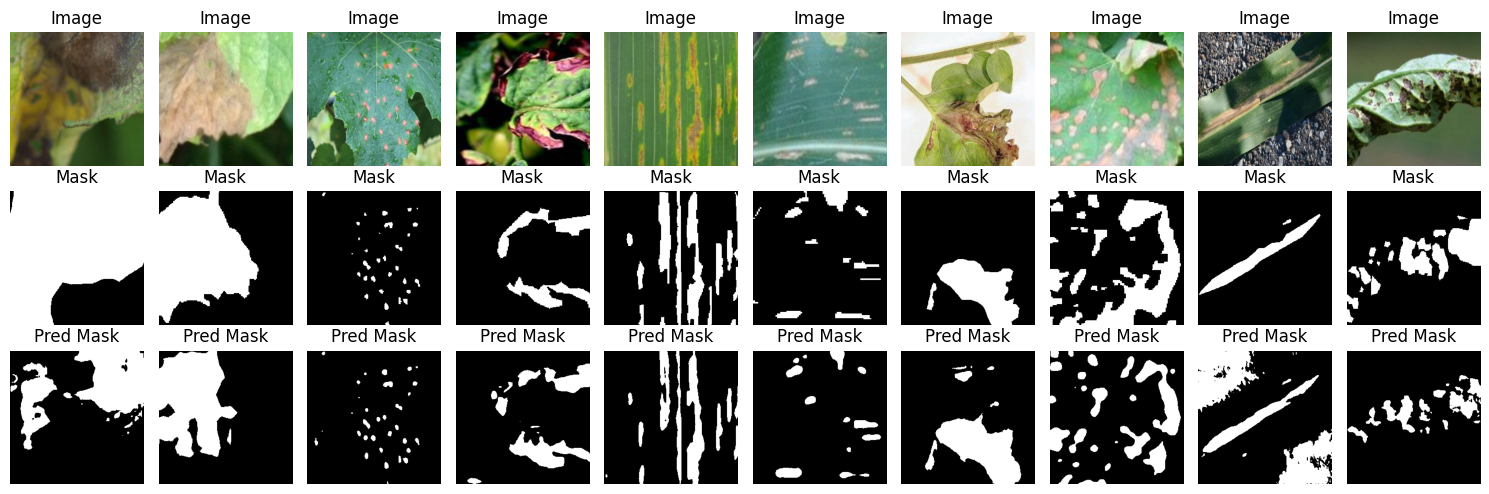

In [ ]:
import matplotlib.pyplot as plt

num_images_to_display = 10
fig, axes = plt.subplots(3, num_images_to_display, figsize=(15, 5))

segmentation_data.setup(None    )

for i in range(num_images_to_display):
    sample = segmentation_data.test_ds[i]  # Get a sample from the dataset
    image, mask = sample  # Unpack the tuple
    with torch.no_grad():
      pred_mask = (lit_model.model(image.unsqueeze(0)) > 0)

    # Convert CHW (Channel-Height-Width) to HWC (Height-Width-Channel)
    image = image.permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
    mask = mask.squeeze().numpy()  # Squeeze single-channel mask tensor
    pred_mask = pred_mask.squeeze().numpy()

    # Plot the image
    axes[0, i].imshow(image)  # Display image
    axes[0, i].axis('off')
    axes[0, i].set_title('Image')

    # Plot the mask
    axes[1, i].imshow(mask, cmap='gray')  # Display mask
    axes[1, i].axis('off')
    axes[1, i].set_title('Mask')

    # Plot the pred mask
    axes[2, i].imshow(pred_mask, cmap='gray')  # Display pred mask
    axes[2, i].axis('off')
    axes[2, i].set_title('Pred Mask')

plt.tight_layout()
plt.show()